In [1]:
import torch
import torch.nn as nn

# 创建输入嵌入 x
x=torch.randn((1,4,1600))
# 创建神经网络
c_attn=nn.Linear(1600,1600*3)
B,T,C=x.size()
# 将输入嵌入传递给神经网络，以创建 Q、K 和 V
q,k,v=c_attn(x).split(1600,dim=2)
# 打印 Q、K 和 V 的大小
print(f"the shape of Q vector is {q.size()}")
print(f"the shape of K vector is {k.size()}")
print(f"the shape of V vector is {v.size()}")

the shape of Q vector is torch.Size([1, 4, 1600])
the shape of K vector is torch.Size([1, 4, 1600])
the shape of V vector is torch.Size([1, 4, 1600])


In [2]:
# 将 Q、K 和 V 分成 25 个注意力头
hs=C//25
k = k.view(B, T, 25, hs).transpose(1, 2) 
q = q.view(B, T, 25, hs).transpose(1, 2) 
v = v.view(B, T, 25, hs).transpose(1, 2)
# 打印多头 Q、K 和 V 的大小
print(f"the shape of Q vector is {q.size()}")
print(f"the shape of K vector is {k.size()}")
print(f"the shape of V vector is {v.size()}")

the shape of Q vector is torch.Size([1, 25, 4, 64])
the shape of K vector is torch.Size([1, 25, 4, 64])
the shape of V vector is torch.Size([1, 25, 4, 64])


In [3]:
import math
scaled_att = (q @ k.transpose(-2, -1)) *\
            (1.0 / math.sqrt(k.size(-1)))
print(scaled_att[0,0]) 

tensor([[ 0.2592,  0.0943, -0.3034,  0.0833],
        [-0.0531,  0.0202,  0.0944, -0.0316],
        [-0.3446, -0.1044,  0.6132,  0.0773],
        [ 0.4473, -0.0781, -0.6020,  0.2397]], grad_fn=<SelectBackward0>)


In [4]:
# print out the scaled attention scores in the second head
print(scaled_att[0,1]) 

tensor([[ 0.1983, -0.6126, -0.1932,  0.3118],
        [-0.2145,  0.4351,  0.0870, -0.1328],
        [ 0.7554, -0.0756, -0.0808,  0.2678],
        [ 0.1954,  0.0598,  0.4298, -0.0878]], grad_fn=<SelectBackward0>)


In [5]:
# 创建一个掩码
mask=torch.tril(torch.ones(4,4))
print(mask)
# 通过将未来词元的值改为 -∞，将掩码应用于缩放后的注意力得分
masked_scaled_att=scaled_att.masked_fill(mask == 0, float('-inf'))
print(masked_scaled_att[0,0]) 

tensor([[1., 0., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 1.]])
tensor([[ 0.2592,    -inf,    -inf,    -inf],
        [-0.0531,  0.0202,    -inf,    -inf],
        [-0.3446, -0.1044,  0.6132,    -inf],
        [ 0.4473, -0.0781, -0.6020,  0.2397]], grad_fn=<SelectBackward0>)


In [6]:
import torch.nn.functional as F
att = F.softmax(masked_scaled_att, dim=-1)
print(att[0,0])

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.4817, 0.5183, 0.0000, 0.0000],
        [0.2050, 0.2607, 0.5343, 0.0000],
        [0.3631, 0.2147, 0.1271, 0.2950]], grad_fn=<SelectBackward0>)


In [7]:
# print out the attention weights in the last head
print(att[0,-1]) 

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.4968, 0.5032, 0.0000, 0.0000],
        [0.3156, 0.4328, 0.2516, 0.0000],
        [0.3560, 0.2125, 0.2560, 0.1755]], grad_fn=<SelectBackward0>)


In [8]:
y=att@v
y = y.transpose(1, 2).contiguous().view(B, T, C)
print(y.shape)

torch.Size([1, 4, 1600])


In [9]:
from bpe import get_encoder

example="This is the original text."
# 实例化 get_encoder() 类
bpe_encoder=get_encoder()
# 分词并打印词元
response=bpe_encoder.encode_and_show_work(example)
print(response["tokens"])

['This', ' is', ' the', ' original', ' text', '.']


In [11]:
print(response['bpe_idx'])

[1212, 318, 262, 2656, 2420, 13]


In [12]:
from bpe import BPETokenizer 
# 实例化 BPETokenizer() 类
tokenizer = BPETokenizer()
# 使用分词器根据索引恢复文本
out=tokenizer.decode(torch.LongTensor(response['bpe_idx']))   
print(out)

This is the original text.


In [13]:
# split the phrase "this is a prompt" into tokens
example="this is a prompt"
bpe_encoder=get_encoder()
response=bpe_encoder.encode_and_show_work(example)
print(response["tokens"])
# After that, map the tokens to indexes
print(response['bpe_idx'])
# Finally, restore the phrase based on the indexes 
out=tokenizer.decode(torch.LongTensor(response['bpe_idx']))   
print(out)

['this', ' is', ' a', ' prompt']
[5661, 318, 257, 6152]
this is a prompt


In [14]:
class GELU(nn.Module):
    def forward(self, x):
        return 0.5*x*(1.0+torch.tanh(math.sqrt(2.0/math.pi)*\
                       (x + 0.044715 * torch.pow(x, 3.0))))

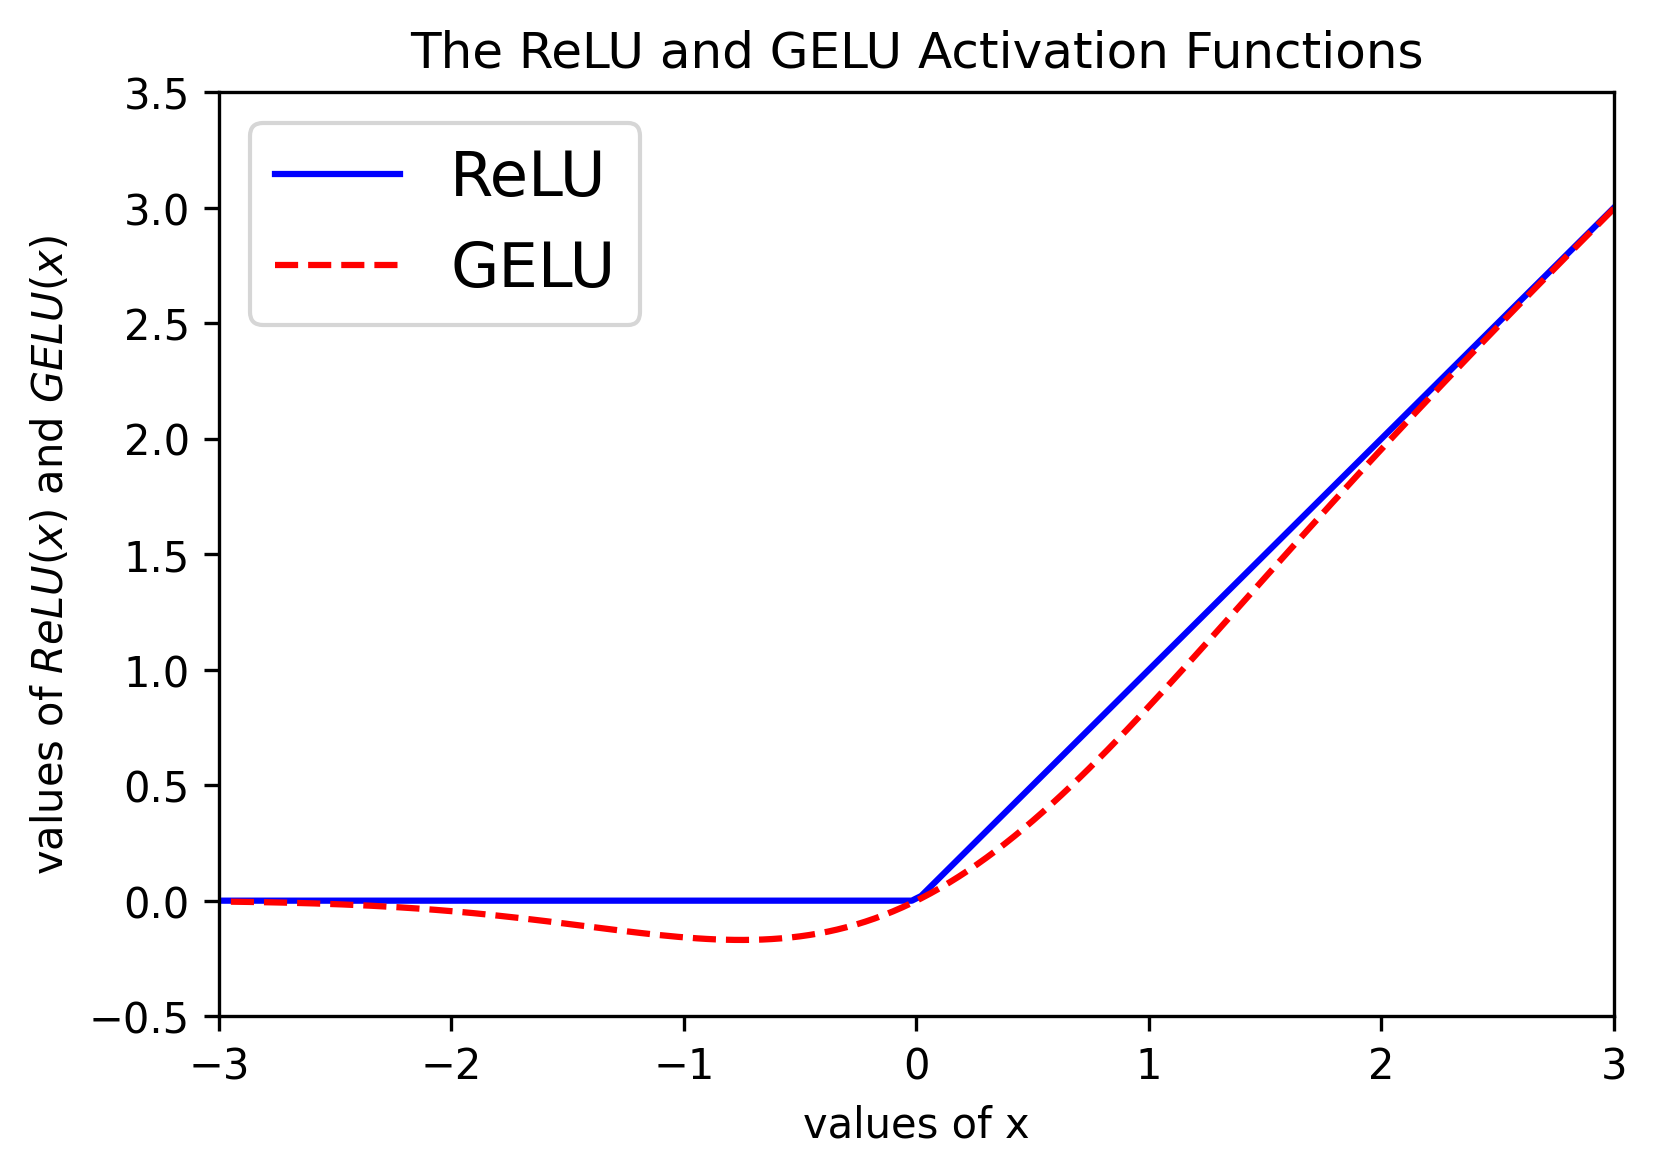

In [15]:
import matplotlib.pyplot as plt
import numpy as np

genu=GELU()
# 定义 ReLU 函数
def relu(x):
    y=torch.zeros(len(x))
    for i in range(len(x)):
        if x[i]>0:
            y[i]=x[i]
    return y                 
xs = torch.linspace(-6,6,300)
ys=relu(xs)
gs=genu(xs)
# 可视化 ReLU 和 GELU 激活函数
fig, ax = plt.subplots(figsize=(6,4),dpi=300)
plt.xlim(-3,3)
plt.ylim(-0.5,3.5)
plt.plot(xs, ys, color = 'blue', label="ReLU")
plt.plot(xs, gs, "--", color = 'red', label="GELU")
plt.legend(fontsize=15)
plt.xlabel("values of x")
plt.ylabel("values of $ReLU(x)$ and $GELU(x)$")
plt.title("The ReLU and GELU Activation Functions")
plt.show()

In [16]:
# 定义 Config() 类
class Config():
    def __init__(self):
        # 将模型超参数作为属性放入类中
        self.n_layer = 48
        self.n_head = 25
        self.n_embd = 1600
        self.vocab_size = 50257
        self.block_size = 1024 
        self.embd_pdrop = 0.1 
        self.resid_pdrop = 0.1 
        self.attn_pdrop = 0.1 
        
# 实例化 Config() 类
config=Config()

In [17]:
class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.attn_dropout = nn.Dropout(config.attn_pdrop)
        self.resid_dropout = nn.Dropout(config.resid_pdrop)
        # 创建一个掩码并将其注册为缓冲区
        self.register_buffer("bias", torch.tril(torch.ones(\
                   config.block_size, config.block_size))
             .view(1, 1, config.block_size, config.block_size))
        self.n_head = config.n_head
        self.n_embd = config.n_embd

    def forward(self, x):
        B, T, C = x.size()
        # 通过神经网络传递输入嵌入，以获得 Q、K 和 V
        q, k ,v  = self.c_attn(x).split(self.n_embd, dim=2)
        # 将 Q、K 和 V 分成多个注意力头
        hs = C // self.n_head
        k = k.view(B, T, self.n_head, hs).transpose(1, 2) 
        q = q.view(B, T, self.n_head, hs).transpose(1, 2) 
        v = v.view(B, T, self.n_head, hs).transpose(1, 2) 

        att = (q @ k.transpose(-2, -1)) *\
            (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, \
                              float('-inf'))
        # 计算每个头中的掩码注意力权重
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        y = att @ v
        # 将所有头中的注意力向量连接成一个单一的注意力向量
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))
        return y

In [18]:
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = nn.ModuleDict(dict(
            c_fc   = nn.Linear(config.n_embd, 4 * config.n_embd),
            c_proj = nn.Linear(4 * config.n_embd, config.n_embd),
            act    = GELU(),
            dropout = nn.Dropout(config.resid_pdrop),
        ))
        m = self.mlp
        self.mlpf=lambda x:m.dropout(m.c_proj(m.act(m.c_fc(x)))) 

    def forward(self, x):
        # 块中的第一个子层是因果自注意力子层，带有层归一化和残差连接
        x = x + self.attn(self.ln_1(x))
        # 块中的第二个子层是前馈神经网络，具有 GELU 激活函数、层归一化和残差连接
        x = x + self.mlpf(self.ln_2(x))
        return x

In [19]:
class GPT2XL(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.block_size = config.block_size
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.embd_pdrop),
            h = nn.ModuleList([Block(config) 
                               for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),))
        self.lm_head = nn.Linear(config.n_embd,
                                 config.vocab_size, bias=False)      
    def forward(self, idx, targets=None):
        b, t = idx.size()
        pos = torch.arange(0,t,dtype=torch.long).unsqueeze(0)
        tok_emb = self.transformer.wte(idx) 
        pos_emb = self.transformer.wpe(pos)
        # 计算输入嵌入作为词嵌入和位置编码的和
        x = self.transformer.drop(tok_emb + pos_emb)
        # 将输入嵌入通过 48 个解码器块
        for block in self.transformer.h:
            x = block(x)
        # 再次应用层归一化
        x = self.transformer.ln_f(x)
        # 添加线性层，使输出的数量等于唯一词元的数量
        logits = self.lm_head(x)
        loss = None
        if targets is not None:
            loss=F.cross_entropy(logits.view(-1,logits.size(-1)),
                           targets.view(-1), ignore_index=-1)
        return logits, loss

In [20]:
model=GPT2XL(config)
num=sum(p.numel() for p in model.transformer.parameters())
print("number of parameters: %.2fM" % (num/1e6,))

number of parameters: 1557.61M


In [21]:
print(model)

GPT2XL(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 1600)
    (wpe): Embedding(1024, 1600)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-47): 48 x Block(
        (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=1600, out_features=4800, bias=True)
          (c_proj): Linear(in_features=1600, out_features=1600, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (mlp): ModuleDict(
          (c_fc): Linear(in_features=1600, out_features=6400, bias=True)
          (c_proj): Linear(in_features=6400, out_features=1600, bias=True)
          (act): GELU()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head

In [22]:
from transformers import GPT2LMHeadModel
# 加载预训练模型权重
model_hf = GPT2LMHeadModel.from_pretrained('gpt2-xl')
# 提取模型权重
sd_hf = model_hf.state_dict()
# 打印出原始 OpenAI GPT-2XL 模型的结构
print(model_hf)

2025-03-08 13:22:16.563959: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-08 13:22:19.772775: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1600)
    (wpe): Embedding(1024, 1600)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-47): 48 x GPT2Block(
        (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=4800, nx=1600)
          (c_proj): Conv1D(nf=1600, nx=1600)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=6400, nx=1600)
          (c_proj): Conv1D(nf=1600, nx=6400)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1600, out_features=50257, bias=False)
)


OpenAI 同样使用 Conv1D 代替线性层

In [23]:
print(model_hf.transformer.h[0].mlp.c_fc.weight.shape) 

torch.Size([1600, 6400])


In [24]:
print(model.transformer.h[0].mlp.c_fc.weight.shape)

torch.Size([6400, 1600])


In [25]:
keys = [k for k in sd_hf if not k.endswith('attn.masked_bias')] 

In [26]:
sd=model.state_dict()

In [27]:
# 找出 OpenAI 使用 Conv1d 模块而不是线性模块的层
transposed = ['attn.c_attn.weight', 'attn.c_proj.weight',
              'mlp.c_fc.weight', 'mlp.c_proj.weight']
for k in keys:
    if any(k.endswith(w) for w in transposed):
        # 对于这些层，在将权重放入模型之前转置权重矩阵
        with torch.no_grad():
            sd[k].copy_(sd_hf[k].t())
    else:
        # 否则，直接从 OpenAI 复制权重并将其放入模型中
        with torch.no_grad():
            sd[k].copy_(sd_hf[k])

In [28]:
model.eval()
def sample(idx, max_new_tokens, temperature=1.0, top_k=None):
    # 生成指定数量的新索引
    for _ in range(max_new_tokens):
        if idx.size(1) <= config.block_size:
            idx_cond = idx  
        else:
            idx_cond = idx[:, -config.block_size:]
        # 使用 GTP-2XL 预测下一索引
        logits, _ = model(idx_cond)
        logits = logits[:, -1, :] / temperature
        # 如果使用 top-K 采样，将低于前 K 个选择的 logits 设置为 –∞
        if top_k is not None:
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float('Inf')
        probs = F.softmax(logits, dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1)
        # 如果下一个标记是 <|endoftext|>，则停止预测
        if idx_next.item()==tokenizer.encoder.encoder['<|endoftext|>']:
            break
        # 将新预测添加到序列中
        idx = torch.cat((idx, idx_next), dim=1)
    return idx 

In [29]:
def generate(prompt, max_new_tokens, temperature=1.0,
             top_k=None):
    if prompt == '':
        x=torch.tensor([[tokenizer.encoder.encoder['<|endoftext|>']]],
                         dtype=torch.long)
    else:
        x = tokenizer(prompt)
    y = sample(x, max_new_tokens, temperature, top_k)
    out = tokenizer.decode(y.squeeze())
    print(out)

In [30]:
prompt=""
generate(prompt, max_new_tokens=100, temperature=1.0,
             top_k=None)

<|endoftext|>Sources close to Speakers' Corner confirmed to Breitbart News that Newt Gingrich was praying in the heat on June 14, just hours after suffering a heated grilling by the House ethics committee:

White House officials could not immediately be reached for comment. Speaker Paul Ryan and members of the House Republican leadership huddled in Boehner's office later that day after negotiations resumed within the delegation, sources said.

...

News of Gingrich's prayer first emerged after Breitbart News published a post from a reporter


In [31]:
prompt=""
generate(prompt, max_new_tokens=100, temperature=0.9,
             top_k=40)  

<|endoftext|>Dryland plants are one of several types of plants that benefit from an annual crop of grasses that are rich in nitrogen. The grasses provide cover and moisture to the soil, and they promote weed growth. Annual grasses also improve soil quality by filtering water and removing fertilizers and organic matter.

Grasses are produced by many grassland and rangeland ecosystems. Annual grass crops also benefit from the annual flood of grass seeds that occurs in some grasslands. These seeds germin


In [32]:
prompt="I went to the kitchen and"
for i in range(5):
    torch.manual_seed(i)
    generate(prompt, max_new_tokens=10, temperature=1.0,
                 top_k=None)

I went to the kitchen and said, you're not going to believe this.
I went to the kitchen and noticed a female producer open a drawer in which was
I went to the kitchen and asked who was going to be right there and A
I went to the kitchen and took a small vial of bourbon and a little
I went to the kitchen and found the bottle of wine, and poured it into


In [33]:
prompt="Lexington is the second largest city in the state of Kentucky"
generate(prompt, max_new_tokens=100, temperature=1.0,
             top_k=None)

Lexington is the second largest city in the state of Kentucky surrounding Louisville where the University of Louisville is located.

Milford Hunt joins the 5-0 team that went undefeated in the 501 Blonsk Football League with the local team Louisville Black Kentucky before their group learned that they would not be allowed to compete at their home tournament due to a defunct balance of the squad rules.

The Boys and Girls High School Division 2 cheerleading team, the Blonsk Court Stars, announced their escape from home with the first round in the 501blons


In [34]:
prompt="Lexington is the second largest city in the state of Kentucky"
generate(prompt, max_new_tokens=100, temperature=0.9,
             top_k=50)

Lexington is the second largest city in the state of Kentucky, and home to a large number of universities and colleges including the University of Kentucky.

4. Nashville

Nashville is also home to a large number of public universities and colleges, including Vanderbilt University and the University of Tennessee. It is also the third largest city in the state of Tennessee.

5. Atlanta

Atlanta is the fifth largest city in the state of Georgia. It is the seventh largest city in the state of Georgia. It is also home to the Georgia


In [35]:
generate(prompt, max_new_tokens=100, temperature=1.2,
             top_k=None) 

Lexington is the second largest city in the state of Kentucky. Richmondð consists entirely of public buildings and bodies of water. The city is rich masonry constructions, referencing early Spanish and Vietnamese influences that come along and challenge the colonial-claimed status of Black citizens in Virginia.[50][51] Zideal Medical Center in Lexington is the first academic medical- supports St. John's County and provides care to passengers on about 800 cargo and into passenger railway cars on coal and salt.

See Also [ edit ]

References [ edit ]
